<a href="https://colab.research.google.com/github/mistiqve/lc_risk_analysis/blob/master/ml_project_yj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import timeit

In [273]:
!pip install xgboost

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pd.set_option('display.max_rows', 200)
# data_path = "/content/drive/My Drive/loan.csv"

data_path = "lending-club-loan-data/loan.csv"
data_desc_path = "lending-club-loan-data/LCDataDictionary.xlsx"

## Load & Preprocess Data

In [128]:
# LOAD ALL DATA

loan_df = pd.read_csv(data_path)
print(loan_df.shape)
loan_df.head()

/Users/Fyxstkala/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260668, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
desc_df = pd.read_excel(data_desc_path, sheet_name='LoanStats')
print(desc_df.shape)
desc_df.head()

(153, 2)


,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


### Missing Values

In [4]:
def get_percent_null_val(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
    return missing_value_df

missing_value_df = get_percent_null_val(loan_df)
missing_value_df

,column_name,percent_missing
id,id,100.000000
url,url,100.000000
member_id,member_id,100.000000
orig_projected_additional_accrued_interest,orig_projected_additional_accrued_interest,99.627278
hardship_length,hardship_length,99.530537
hardship_reason,hardship_reason,99.530537
hardship_status,hardship_status,99.530537
deferral_term,deferral_term,99.530537
hardship_amount,hardship_amount,99.530537
hardship_start_date,hardship_start_date,99.530537


In [5]:
col_to_remove = missing_value_df.loc[missing_value_df.percent_missing>80].column_name.tolist()
print(len(col_to_remove))
df = loan_df.drop(col_to_remove, axis=1).dropna()
print(df.shape)
df.head()

39
(75170, 106)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
8,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Legal Assistant III,10+ years,...,60.0,0.0,0.0,57426.0,41882.0,21500.0,34626.0,N,Cash,N
18,16000,16000,16000.0,60 months,20.89,431.87,D,D4,Neonatal Nurse Practitioner,4 years,...,100.0,0.0,0.0,444217.0,266754.0,13500.0,239338.0,N,Cash,N
23,3500,3500,3500.0,36 months,20.89,131.67,D,D4,gas attendant,10+ years,...,0.0,0.0,0.0,217000.0,26902.0,5000.0,25000.0,N,Cash,N
31,10000,10000,10000.0,60 months,19.92,264.50,D,D3,Material Handler,10+ years,...,50.0,0.0,0.0,170230.0,37606.0,8000.0,55030.0,N,Cash,N
32,16000,16000,16000.0,60 months,17.97,406.04,D,D1,Instructional Coordinator,5 years,...,0.0,0.0,0.0,67924.0,39339.0,29500.0,38424.0,N,Cash,N


### Feature Selection

In [130]:
loan_df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                919695 
Charged Off                                            261655 
Late (31-120 days)                                     21897  
In Grace Period                                        8952   
Late (16-30 days)                                      3737   
Does not meet the credit policy. Status:Fully Paid     1988   
Does not meet the credit policy. Status:Charged Off    761    
Default                                                31     
Name: loan_status, dtype: int64

In [167]:
features_ls = ['home_ownership','annual_inc','delinq_2yrs','emp_length','grade',
              'loan_status','mort_acc', 'mo_sin_old_rev_tl_op', 'mths_since_last_delinq',
              'inq_fi','open_acc','pub_rec','pub_rec_bankruptcies', 'term','loan_amnt',
              'int_rate','last_pymnt_amnt','total_bc_limit','verification_status','purpose']
print(len(features_ls))

20


In [132]:
df = loan_df[loan_df.columns & features_ls].dropna()              
print(df.shape)
df.head()

(633572, 20)


,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,delinq_2yrs,mths_since_last_delinq,open_acc,pub_rec,last_pymnt_amnt,inq_fi,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,total_bc_limit
1,30000,60 months,18.94,D,10+ years,MORTGAGE,90000.0,Source Verified,Current,debt_consolidation,0.0,71.0,13.0,1.0,777.23,2.0,378.0,3.0,1.0,15000.0
8,5000,36 months,17.97,D,10+ years,MORTGAGE,53580.0,Source Verified,Current,debt_consolidation,0.0,32.0,8.0,0.0,180.69,2.0,244.0,3.0,0.0,21500.0
9,6000,36 months,14.47,C,< 1 year,OWN,300000.0,Not Verified,Current,debt_consolidation,1.0,17.0,38.0,0.0,206.44,2.0,200.0,1.0,0.0,98300.0
10,5500,36 months,22.35,D,< 1 year,MORTGAGE,50000.0,Not Verified,Current,credit_card,1.0,22.0,6.0,0.0,211.05,2.0,105.0,3.0,0.0,4800.0
13,6500,36 months,17.97,D,4 years,MORTGAGE,154000.0,Source Verified,Current,debt_consolidation,2.0,6.0,27.0,0.0,234.90,3.0,74.0,0.0,0.0,12300.0


In [133]:
pd.set_option('display.max_colwidth',-1)

desc_df[desc_df['LoanStatNew'].isin(features_ls)]

,LoanStatNew,Description
4,annual_inc,The self-reported annual income provided by the borrower during registration.
16,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
23,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
29,grade,LC assigned loan grade
42,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
46,inq_fi,Number of personal finance inquiries
50,int_rate,Interest Rate on the loan
55,last_pymnt_amnt,Last total payment amount received
57,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
58,loan_status,Current status of the loan


#### Feature Plots

(633572, 20) (13, 13)


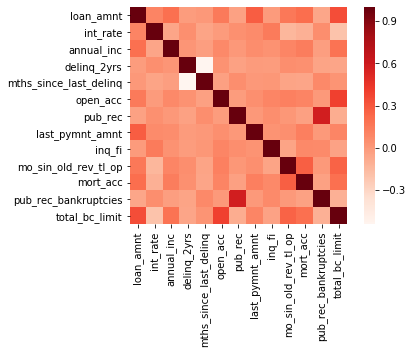

In [136]:
# Feature Correlation 

cor = df.corr()
print(df.shape, cor.shape)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds, square = True)
plt.show()

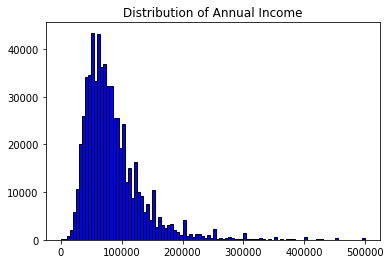

In [20]:
plt.title("Distribution of Annual Income")
plt.hist(df['annual_inc'], color = 'blue', edgecolor = 'black', range=[0, 500000],
         bins = 100)
plt.show()

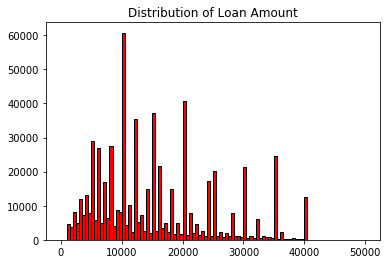

In [21]:
plt.title("Distribution of Loan Amount")
plt.hist(df['loan_amnt'], color = 'red', edgecolor = 'black', range=[0, 50000],
         bins = 100)
plt.show()

### Data Preprocessing 

In [137]:
df0 = df.drop(['loan_status','grade','home_ownership','term','verification_status','purpose'], axis=1)
print(type(df0), df0.shape)
df0.head()

<class 'pandas.core.frame.DataFrame'> (633572, 14)


,loan_amnt,int_rate,emp_length,annual_inc,delinq_2yrs,mths_since_last_delinq,open_acc,pub_rec,last_pymnt_amnt,inq_fi,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,total_bc_limit
1,30000,18.94,10+ years,90000.0,0.0,71.0,13.0,1.0,777.23,2.0,378.0,3.0,1.0,15000.0
8,5000,17.97,10+ years,53580.0,0.0,32.0,8.0,0.0,180.69,2.0,244.0,3.0,0.0,21500.0
9,6000,14.47,< 1 year,300000.0,1.0,17.0,38.0,0.0,206.44,2.0,200.0,1.0,0.0,98300.0
10,5500,22.35,< 1 year,50000.0,1.0,22.0,6.0,0.0,211.05,2.0,105.0,3.0,0.0,4800.0
13,6500,17.97,4 years,154000.0,2.0,6.0,27.0,0.0,234.90,3.0,74.0,0.0,0.0,12300.0


#### Encode Employment Length

In [138]:
#Process emp_length
#RUN ONLY ONCE
# Categorize employment length feature
df0.loc[df0.emp_length == "< 1 year", 'emp_length'] = 0
df0.loc[df0.emp_length == "1 year", 'emp_length'] = 0
df0.loc[df0.emp_length == "2 years", 'emp_length'] = 0
df0.loc[df0.emp_length == "3 years", 'emp_length'] = 0
df0.loc[df0.emp_length == "4 years", 'emp_length'] = 1
df0.loc[df0.emp_length == "5 years", 'emp_length'] = 1
df0.loc[df0.emp_length == "6 years", 'emp_length'] = 1
df0.loc[df0.emp_length == "7 years", 'emp_length'] = 2
df0.loc[df0.emp_length == "8 years", 'emp_length'] = 2
df0.loc[df0.emp_length == "9 years", 'emp_length'] = 2
df0.loc[df0.emp_length == "10+ years", 'emp_length'] = 3

df0['emp_length'].value_counts()
df0.drop(['emp_length'],axis = 1)

,loan_amnt,int_rate,annual_inc,delinq_2yrs,mths_since_last_delinq,open_acc,pub_rec,last_pymnt_amnt,inq_fi,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,total_bc_limit
1,30000,18.94,90000.0,0.0,71.0,13.0,1.0,777.23,2.0,378.0,3.0,1.0,15000.0
8,5000,17.97,53580.0,0.0,32.0,8.0,0.0,180.69,2.0,244.0,3.0,0.0,21500.0
9,6000,14.47,300000.0,1.0,17.0,38.0,0.0,206.44,2.0,200.0,1.0,0.0,98300.0
10,5500,22.35,50000.0,1.0,22.0,6.0,0.0,211.05,2.0,105.0,3.0,0.0,4800.0
13,6500,17.97,154000.0,2.0,6.0,27.0,0.0,234.90,3.0,74.0,0.0,0.0,12300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260654,30000,17.09,80000.0,0.0,46.0,21.0,0.0,747.03,0.0,171.0,0.0,0.0,49300.0
2260655,18000,30.65,77000.0,0.0,38.0,9.0,0.0,619.05,0.0,52.0,1.0,0.0,13800.0
2260658,15000,16.02,85000.0,0.0,36.0,19.0,0.0,14613.69,1.0,198.0,1.0,0.0,22900.0
2260660,10000,12.62,65000.0,0.0,29.0,5.0,0.0,335.12,0.0,163.0,0.0,0.0,13300.0


#### Encode Term

In [139]:
#catogorize term to 0('36month') and 1('60month')
df0['term'] = df['term'].factorize()[0]
df0.head()

,loan_amnt,int_rate,emp_length,annual_inc,delinq_2yrs,mths_since_last_delinq,open_acc,pub_rec,last_pymnt_amnt,inq_fi,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,total_bc_limit,term
1,30000,18.94,3,90000.0,0.0,71.0,13.0,1.0,777.23,2.0,378.0,3.0,1.0,15000.0,0
8,5000,17.97,3,53580.0,0.0,32.0,8.0,0.0,180.69,2.0,244.0,3.0,0.0,21500.0,1
9,6000,14.47,0,300000.0,1.0,17.0,38.0,0.0,206.44,2.0,200.0,1.0,0.0,98300.0,1
10,5500,22.35,0,50000.0,1.0,22.0,6.0,0.0,211.05,2.0,105.0,3.0,0.0,4800.0,1
13,6500,17.97,1,154000.0,2.0,6.0,27.0,0.0,234.90,3.0,74.0,0.0,0.0,12300.0,1


#### Log Transform

In [140]:
#Take log transformation for some features
df['total_bc_limit'] = np.log(1+df['total_bc_limit'])
df['last_pymnt_amnt'] = np.log(1+df['last_pymnt_amnt'])
df['int_rate'] = np.log(1+df['int_rate']/100)
df['annual_inc'] = np.log(1+df['annual_inc'])
df['loan_amnt'] = np.log(1+df['loan_amnt'])

#### One Hot Encoding

In [141]:
# One hot encoder home_ownership, verification_status, purpose and grade
df0['home_ownership'] = df['home_ownership']
df0 = pd.get_dummies(df0, columns=['home_ownership'], prefix = ['home'])
df0['grade']=df['grade']
df0 = pd.get_dummies(df0, columns = ['grade'], prefix=['grade'])
df0['verification_status'] = df['verification_status']
df0 = pd.get_dummies(df0, columns = ['verification_status'], prefix=['verification_status'] )
df0['purpose'] = df['purpose']
df0 = pd.get_dummies(df0, columns = ['purpose'], prefix=['purpose'] )

df0.head()

,loan_amnt,int_rate,emp_length,annual_inc,delinq_2yrs,mths_since_last_delinq,open_acc,pub_rec,last_pymnt_amnt,inq_fi,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
1,30000,18.94,3,90000.0,0.0,71.0,13.0,1.0,777.23,2.0,...,0,0,0,0,0,0,0,0,0,0
8,5000,17.97,3,53580.0,0.0,32.0,8.0,0.0,180.69,2.0,...,0,0,0,0,0,0,0,0,0,0
9,6000,14.47,0,300000.0,1.0,17.0,38.0,0.0,206.44,2.0,...,0,0,0,0,0,0,0,0,0,0
10,5500,22.35,0,50000.0,1.0,22.0,6.0,0.0,211.05,2.0,...,0,0,0,0,0,0,0,0,0,0
13,6500,17.97,1,154000.0,2.0,6.0,27.0,0.0,234.90,3.0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
df0.columns

Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'delinq_2yrs',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'last_pymnt_amnt',
       'inq_fi', 'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'total_bc_limit', 'term', 'home_ANY', 'home_MORTGAGE', 'home_NONE',
       'home_OWN', 'home_RENT', 'grade_A', 'grade_B', 'grade_C', 'grade_D',
       'grade_E', 'grade_F', 'grade_G', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [143]:
#Remove some dummy variables that is of tiny fraction
df0 = df0.drop(['home_ANY', 'grade_D','verification_status_Verified','purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding','purpose_car'], axis=1)
df0.columns

Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'delinq_2yrs',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'last_pymnt_amnt',
       'inq_fi', 'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'total_bc_limit', 'term', 'home_MORTGAGE', 'home_NONE', 'home_OWN',
       'home_RENT', 'grade_A', 'grade_B', 'grade_C', 'grade_E', 'grade_F',
       'grade_G', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'purpose_credit_card',
       'purpose_debt_consolidation'],
      dtype='object')

#### Scaling

In [144]:
# Scaling By Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df0[df0.columns] = scaler.fit_transform(df0[df0.columns])
df0.head()

,loan_amnt,int_rate,emp_length,annual_inc,delinq_2yrs,mths_since_last_delinq,open_acc,pub_rec,last_pymnt_amnt,inq_fi,...,grade_A,grade_B,grade_C,grade_E,grade_F,grade_G,verification_status_Not Verified,verification_status_Source Verified,purpose_credit_card,purpose_debt_consolidation
1,1.560529,1.107743,1.126292,0.033386,-0.531504,1.662099,0.155372,1.376838,-0.368747,0.538788,...,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565
8,-1.073791,0.914088,1.126292,-0.284126,-0.531504,-0.121667,-0.702998,-0.316069,-0.470411,0.538788,...,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565
9,-0.968418,0.215332,-1.187734,1.864178,0.323876,-0.807731,4.447225,-0.316069,-0.466022,0.538788,...,-0.440119,-0.659985,1.466192,-0.23123,-0.122712,-0.071628,1.416969,-0.868951,-0.508454,0.887565
10,-1.021104,1.788530,-1.187734,-0.315337,0.323876,-0.579043,-1.046347,-0.316069,-0.465237,0.538788,...,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,1.416969,-0.868951,1.966746,-1.126678
13,-0.915732,0.914088,-0.416392,0.591342,1.179256,-1.310845,2.558810,-0.316069,-0.461172,1.162132,...,-0.440119,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565


(30, 30)


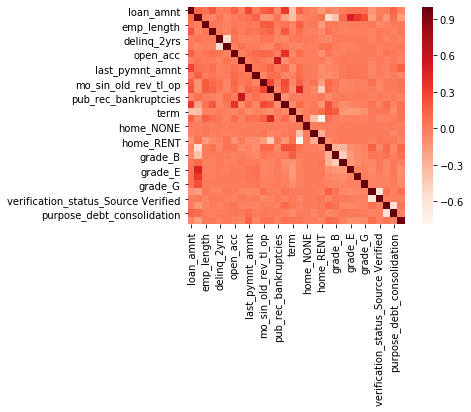

In [166]:
cor = df0.corr()
print(cor.shape)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds, square = True)
plt.show()

#### Encode Target Feature

In [148]:
df0['loan_status'] = df['loan_status']
df0['loan_status'].value_counts()

Current               379034
Fully Paid            184277
Charged Off           54713 
Late (31-120 days)    9771  
In Grace Period       4148  
Late (16-30 days)     1609  
Default               20    
Name: loan_status, dtype: int64

In [149]:
df0.loc[df0.loan_status == "Current", 'loan_status'] = 1
df0.loc[df0.loan_status == "Fully Paid", 'loan_status'] = 1
df0.loc[df0.loan_status == "In Grace Period", 'loan_status'] = 0
df0.loc[df0.loan_status == "Late (31-120 days)", 'loan_status'] = 0
df0.loc[df0.loan_status == "Late (16-30 days)", 'loan_status'] = 0
df0.loc[df0.loan_status == "Default", 'loan_status'] = 0
df0.loc[df0.loan_status == "Charged Off", 'loan_status'] = 0

In [150]:
df0['loan_status'].value_counts()

1    563311
0    70261 
Name: loan_status, dtype: int64

In [151]:
df_bad = df0[df0['loan_status']==0]
df_good = df0[df0['loan_status']==1].sample(n=len(df_bad))
df_downsampled = pd.concat([df_good,df_bad])
df_downsampled.head()

,loan_amnt,int_rate,emp_length,annual_inc,delinq_2yrs,mths_since_last_delinq,open_acc,pub_rec,last_pymnt_amnt,inq_fi,...,grade_B,grade_C,grade_E,grade_F,grade_G,verification_status_Not Verified,verification_status_Source Verified,purpose_credit_card,purpose_debt_consolidation,loan_status
108852,-0.336181,1.497049,-1.187734,-0.446107,0.323876,-0.944944,0.155372,-0.316069,-0.424271,-0.084556,...,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565,1
728482,-0.114898,-1.098327,1.126292,-0.053795,-0.531504,0.015545,0.327046,-0.316069,0.089107,-0.707899,...,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,1.416969,-0.868951,1.966746,-1.126678,1
124919,-0.757672,0.325137,-0.416392,-0.245592,-0.531504,0.107021,-0.187976,-0.316069,-0.453927,-0.707899,...,-0.659985,1.466192,-0.23123,-0.122712,-0.071628,-0.705732,-0.868951,-0.508454,-1.126678,1
752047,-0.757672,-1.611413,-1.187734,-0.377235,-0.531504,0.472922,0.670395,-0.316069,-0.460158,-0.707899,...,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565,1
271380,0.506801,1.688708,-1.187734,0.076976,-0.531504,0.427184,-0.702998,-0.316069,-0.407356,1.785476,...,-0.659985,-0.682039,-0.23123,-0.122712,-0.071628,-0.705732,1.150813,-0.508454,0.887565,1


In [162]:
corr = df0.corr()['loan_status'].sort_values()
corr = corr.loc[~corr.index.isin(['loan_status'])]

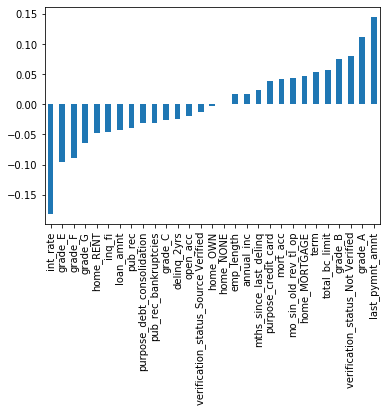

In [163]:
corr.plot(kind='bar')

#### Get X, y

In [55]:
X = df_downsampled.drop(['loan_status'], axis=1).to_numpy()
y = df_downsampled['loan_status'].to_numpy()
print(X.shape, y.shape)
print(type(X), type(y))

(140522, 29) (140522,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Split Data

In [56]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2, 
                                                            random_state=42, 
                                                            stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                test_size=0.25, 
                                                random_state=42, 
                                                stratify = y_train_val)
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({1: 42156, 0: 42156})
Counter({1: 14053, 0: 14052})
Counter({0: 14053, 1: 14052})


In [57]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(84312, 29) (84312,)
(28105, 29) (28105,)
(28105, 29) (28105,)



## Logistic Regression

In [281]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

logistic = LogisticRegression(max_iter=5000, penalty = 'l2', solver = 'lbfgs')

logistic.fit(X_train, y_train)

y_pred_train = logistic.predict(X_train)
y_pred_test_logistic = logistic.predict(X_test)

accuracy_train = accuracy_score(y_pred_train, y_train)
accuracy_test = accuracy_score(y_pred_test_logistic, y_test)

print("Logistic Regression ---")
print("Training accuracy is: ", accuracy_train)
print("Testing accuracy is: ", accuracy_test)


Logistic Regression ---
Training accuracy is:  0.7019404118037764
Testing accuracy is:  0.7017256715886853
CPU times: user 708 ms, sys: 36.4 ms, total: 744 ms
Wall time: 420 ms


In [293]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_logistic).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

10789 3264 5119 8933
              precision    recall  f1-score   support

           0       0.83      0.74      0.78     15904
           1       0.70      0.81      0.75     12201

    accuracy                           0.77     28105
   macro avg       0.77      0.77      0.77     28105
weighted avg       0.78      0.77      0.77     28105



## PCA

In [97]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)

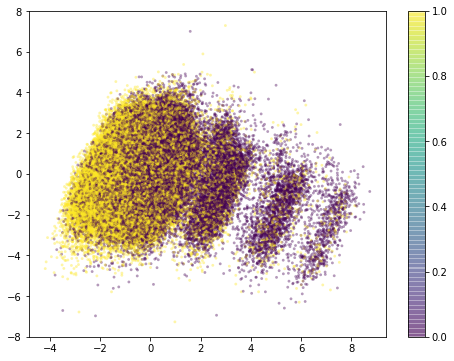

In [100]:
plt.figure(figsize=(8, 6))
plt.plot
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_train, edgecolor='none', 
            alpha=0.4, s = 8)
#plt.xlim(-10, 30)
#plt.ylim(-10, 25)
plt.colorbar()
plt.show()

## Neural Net

In [66]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from matplotlib.pyplot import figure
from torch.utils.data import Dataset, DataLoader

In [67]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

In [241]:
class Dataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        if self.transform is not None:
            item = self.transform(item)
        return (item, self.labels[index])

In [242]:
batch_size = 96

train_data = Dataset(X_train, y_train)
val_data = Dataset(X_val, y_val)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size,
                              shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size,
                              shuffle = True)

In [257]:
class Net(nn.Module):
    def __init__(self, n = 1000):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(16, 2),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.net(x)
        return x

In [258]:
def train_model(model, loss_fn, epochs, train_loader, val_loader, optimizer):

    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []

    model = model.to(device)
    loss_fn = loss_fn.cuda(device)
  
    for epoch in range(epochs):
        correct = 0.0
        cum_loss = 0.0

        for (i, (inputs, labels)) in enumerate(train_loader):
            inputs = Variable(inputs.float().to(device))
            labels = Variable(labels.to(device))
            pred = model(inputs)
            loss = loss_fn(pred, labels)

            _, max_labels = pred.max(1)
            correct += (max_labels == labels).sum().item()
            cum_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 400 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batch_size)))

        train_accuracies.append(correct / len(y_train))
        train_losses.append(cum_loss / (i + 1))   

        # Validation.
        correct = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):
            inputs = Variable(inputs.float().to(device))
            labels = Variable(labels.to(device))

            pred = model(inputs)
            cum_loss += loss_fn(pred, labels).item()

            _, max_labels = pred.max(1)
            correct += (max_labels == labels).sum().item()

        val_accuracies.append(correct / len(y_val))
        val_losses.append(cum_loss / (i + 1))

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(y_val)))
        
    return model, train_accuracies, train_losses, val_accuracies, val_losses

In [264]:
%%time

num_epochs = 20
learning_rate = 0.0005
print("Size of input:", X_train.shape[1])
model = Net(n = X_train.shape[1])
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trained_model, train_acc, train_loss, val_acc, val_loss = train_model(model, criterion, 
                                                num_epochs, train_loader, val_loader, optimizer)

Size of input: 29
Train-epoch 0. Iteration 00400, Avg-Loss: 0.6316, Accuracy: 0.6638
Train-epoch 0. Iteration 00800, Avg-Loss: 0.6097, Accuracy: 0.6820
Validation-epoch 0. Avg-Loss: 0.5837, Accuracy: 0.7055
Train-epoch 1. Iteration 00400, Avg-Loss: 0.5796, Accuracy: 0.7082
Train-epoch 1. Iteration 00800, Avg-Loss: 0.5802, Accuracy: 0.7063
Validation-epoch 1. Avg-Loss: 0.5806, Accuracy: 0.7086
Train-epoch 2. Iteration 00400, Avg-Loss: 0.5771, Accuracy: 0.7107
Train-epoch 2. Iteration 00800, Avg-Loss: 0.5790, Accuracy: 0.7078
Validation-epoch 2. Avg-Loss: 0.5795, Accuracy: 0.7083
Train-epoch 3. Iteration 00400, Avg-Loss: 0.5766, Accuracy: 0.7124
Train-epoch 3. Iteration 00800, Avg-Loss: 0.5768, Accuracy: 0.7101
Validation-epoch 3. Avg-Loss: 0.5792, Accuracy: 0.7094
Train-epoch 4. Iteration 00400, Avg-Loss: 0.5759, Accuracy: 0.7120
Train-epoch 4. Iteration 00800, Avg-Loss: 0.5761, Accuracy: 0.7111
Validation-epoch 4. Avg-Loss: 0.5782, Accuracy: 0.7109
Train-epoch 5. Iteration 00400, Avg-L

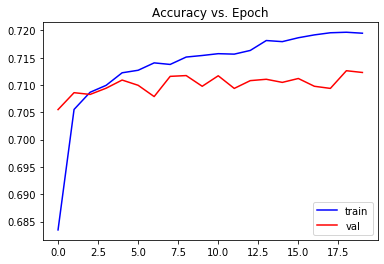

In [265]:
plt.figure()
plt.title("Accuracy vs. Epoch")
plt.plot(range(num_epochs), train_acc, color = "b", label = "train")
plt.plot(range(num_epochs), val_acc, color = "r", label = "val")
plt.legend(loc="lower right")

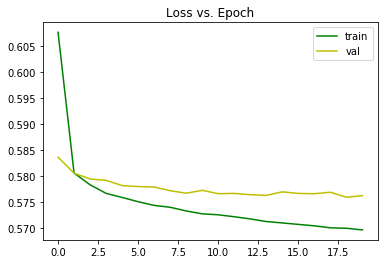

In [266]:
plt.figure()
plt.title("Loss vs. Epoch")
plt.plot(range(num_epochs), train_loss, color = "g", label="train")
plt.plot(range(num_epochs), val_loss, color = "y", label="val")
plt.legend(loc="upper right")

In [282]:
output_test = trained_model(torch.Tensor(X_test)).detach().numpy()
y_pred_test_nn = output_test.argmax(axis=1)+1
print(Counter(y_pred_test_nn))
print(Counter(y_test))

Counter({1: 16725, 2: 11380})
Counter({0: 14053, 1: 14052})


In [283]:
accuracy_test = accuracy_score(y_pred_test_nn-1, y_test)
print("Testing accuracy is: ", accuracy_test)
print(confusion_matrix(y_test, y_pred_test_nn-1))
print(classification_report(y_test, y_pred_test_nn-1))

Testing accuracy is:  0.7115104074008184
[[11335  2718]
 [ 5390  8662]]
              precision    recall  f1-score   support

           0       0.68      0.81      0.74     14053
           1       0.76      0.62      0.68     14052

    accuracy                           0.71     28105
   macro avg       0.72      0.71      0.71     28105
weighted avg       0.72      0.71      0.71     28105



## SVM

In [0]:
from sklearn import svm
import timeit

### RBF kernel

In [0]:
# start_RBF = timeit.default_timer()
# clf = svm.SVC() #rbf kernel
# clf.fit(X_train,y_train)
# end_RBF = timeit.default_timer()
# print(f'Runtime for RBF kernel SVM: {end_RBF-start_RBF}')
# y_pred = clf.predict(X_test)
# y_train_pred = clf.predict(X_train)
# train_accuracy = accuracy_score(y_train_pred,y_train)
# accuracy = accuracy_score(y_pred, y_test)
# print(f'Train accuracy: {train_accuracy}')
# print(f'Test accuracy: {accuracy}')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Runtime for RBF kernel SVM: 1315.620016415
Train accuracy: 0.7223893233518258
Test accuracy: 0.708908138167041


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

11610 2443 5723 8277
              precision    recall  f1-score   support

           0       0.83      0.67      0.74     17333
           1       0.59      0.77      0.67     10720

    accuracy                           0.71     28053
   macro avg       0.71      0.72      0.70     28053
weighted avg       0.74      0.71      0.71     28053



### Poly kernel

In [0]:
start_poly = timeit.default_timer()
clf = svm.SVC(kernel = 'poly') #poly kernel
clf.fit(X_train,y_train)
end_poly = timeit.default_timer()
print(f'Runtime for poly kernel SVM: {end_poly-start_poly}')
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train_pred,y_train)
accuracy = accuracy_score(y_pred, y_test)
print(f'Train accuracy: {train_accuracy}')
print(f'Test accuracy: {accuracy}')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Runtime for poly kernel SVM: 1744.0473658489996
Train accuracy: 0.7150034534233451
Test accuracy: 0.7075179125227249


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

11468 2585 5620 8380
              precision    recall  f1-score   support

           0       0.82      0.67      0.74     17088
           1       0.60      0.76      0.67     10965

    accuracy                           0.71     28053
   macro avg       0.71      0.72      0.70     28053
weighted avg       0.73      0.71      0.71     28053



### Linear kernel

In [0]:
start_linear = timeit.default_timer()
clf = svm.SVC(kernel = 'linear',max_iter = 10000) #linear kernel and set max_iter to 10000 otherwise it does not stop 
clf.fit(X_train,y_train)
end_linear = timeit.default_timer()
print(f'Runtime for linear kernel SVM: {end_linear-start_linear}')
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train_pred,y_train)
accuracy = accuracy_score(y_pred, y_test)
print(f'Train accuracy: {train_accuracy}')
print(f'Test accuracy: {accuracy}')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Runtime for linear kernel SVM: 151.00151250499948
Train accuracy: 0.5368625091905621
Test accuracy: 0.5353081666844901


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

4886 9167 3869 10131
              precision    recall  f1-score   support

           0       0.35      0.56      0.43      8755
           1       0.72      0.52      0.61     19298

    accuracy                           0.54     28053
   macro avg       0.54      0.54      0.52     28053
weighted avg       0.61      0.54      0.55     28053



## XGBOOST

### Gridsearch for optimal hyperparameter

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
#grid search for optimal hyperparameter
start_xgbgrid = timeit.default_timer()
hyperparameters ={'max_depth': [3, 5, 10],'n_estimators': [400, 600, 800]}
model = GridSearchCV(xgb.XGBClassifier(random_state=1), hyperparameters)
model.fit(X_train, y_train)
end_xgbgrid = timeit.default_timer()
# print runtime of model fitting
print("--- %s seconds ---" % (end_xgbgrid - start_xgbgrid))
y_pred = model.predict(X_test)
test_score = accuracy_score(y_pred,y_test)
print('test accuracy',test_score,'best parameter',model.best_params_,'train accuracy',accuracy_score(model.predict(X_train), y_train))

In [0]:
print('test accuracy',test_score,'best parameter',model.best_params_,'train accuracy',accuracy_score(model.predict(X_train), y_train))

test accuracy 0.7662638576979289 best parameter {'max_depth': 5, 'n_estimators': 600} train accuracy 0.8048927210747945


### Optimal model evaluation

In [277]:
start_xgb = timeit.default_timer()
model_opt = xgb.XGBClassifier(random_state=1,max_depth=5,n_estimators=600)
model_opt.fit(X_train, y_train)
end_xgb = timeit.default_timer()
# print runtime of model fitting
print("--- %s seconds ---" % (end_xgb - start_xgb))
y_pred = model_opt.predict(X_test)
test_score = accuracy_score(y_pred,y_test)
print('test accuracy',test_score,'train accuracy',accuracy_score(model_opt.predict(X_train), y_train))

--- 61.66395607707091 seconds ---
test accuracy 0.7690446539761608 train accuracy 0.8066348799696366


In [294]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

11733 2320 4171 9881
              precision    recall  f1-score   support

           0       0.83      0.74      0.78     15904
           1       0.70      0.81      0.75     12201

    accuracy                           0.77     28105
   macro avg       0.77      0.77      0.77     28105
weighted avg       0.78      0.77      0.77     28105



## Adaboost

In [164]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import time
start_time = time.time()
# record initializing time
Test_Score = []
CV_Score = []
num_estimators= [200,300,400,500,600]
# the candidate hyperparameters needed to be tuned
for n_esti in num_estimators:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=n_esti)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("--- %s seconds ---" % (time.time() - start_time))
    # print runtime of model fit under each hyperparameter
    print('num_of_estimators',n_esti ,'train accuracy', accuracy_score(clf.predict(X_train), y_train))
    # print training error and the corresponding number of estimators
    Test_Score.append(accuracy_score(y_pred,y_test))
    CV_Score.append(np.mean(cross_val_score(clf, X_train, y_train, cv=5)))
    # record test score and CV score in order to use for the comparison in the plot
print(Test_Score,CV_Score)

--- 25.433857917785645 seconds ---
num_of_estimators 200 train accuracy 0.7250687921055129
--- 150.20058798789978 seconds ---
num_of_estimators 300 train accuracy 0.7314854350507638
--- 332.1296820640564 seconds ---
num_of_estimators 400 train accuracy 0.7357671505835468
--- 570.7602488994598 seconds ---
num_of_estimators 500 train accuracy 0.7404877123066704
--- 862.1104879379272 seconds ---
num_of_estimators 600 train accuracy 0.743856153335231
[0.7244618395303327, 0.7305461661626045, 0.7343888987724604, 0.7387297633872977, 0.7407934531222202] [0.7213209903835961, 0.7281408636510646, 0.7333714121914314, 0.7368347225732631, 0.7398354811026534]


11494 2559 4726 9326
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     16220
           1       0.66      0.78      0.72     11885

    accuracy                           0.74     28105
   macro avg       0.74      0.75      0.74     28105
weighted avg       0.75      0.74      0.74     28105



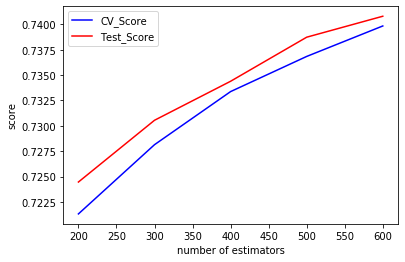

In [165]:
# plot CV accuracy and test accuracy as number of estimators
plt.figure()
plt.plot(num_estimators, CV_Score, color = "b",label='CV_Score')
plt.plot(num_estimators, Test_Score, color = "r",label='Test_Score')
plt.legend()
plt.xlabel('number of estimators')
plt.ylabel('score')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time
hyperparameters ={'max_depth': [3, 5, 10],'n_estimators': [400, 600, 800]}
clf = GridSearchCV(RandomForestClassifier(), hyperparameters)
start_time = time.time()
clf.fit(X_train, y_train)
# print runtime of model fitting
print("--- %s seconds ---" % (time.time() - start_time))
y_pred = clf.predict(X_test)
test_score = accuracy_score(y_pred,y_test)
print('test accuracy',test_score,'best parameter',clf.best_params_,'train accuracy',accuracy_score(clf.predict(X_train), y_train))
# report evaluation table
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_pred, y_test))

## Plot Helper Functions

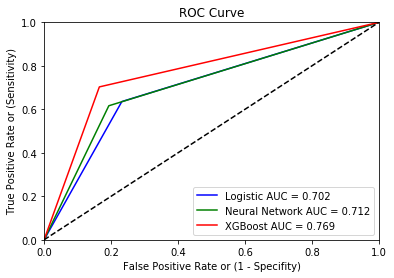

In [292]:
###RUN THIS AFTER MODELS###

# Compute fpr, tpr, thresholds and roc auc
fpr_logis, tpr_logis, thresholds_logis = roc_curve(y_test, y_pred_test_logistic)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_test_nn)
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, y_pred)
auc_logis = roc_auc_score(y_test, y_pred_test_logistic)
auc_nn = roc_auc_score(y_test, y_pred_test_nn)
auc_xg = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr_logis, tpr_logis, label='Logistic AUC = %0.3f' % auc_logis, c="b")
plt.plot(fpr_nn, tpr_nn, label='Neural Network AUC = %0.3f' % auc_nn, c="g")
plt.plot(fpr_xg, tpr_xg, label='XGBoost AUC = %0.3f' % auc_xg, c="r")

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [365]:
def plot_heat_maps(mat_list, titles = None, num_ticks = 10):
  fig,axn = plt.subplots(1, len(mat_list), sharey="row", 
                         figsize=(12, 7))
  plt.subplots_adjust(hspace=0.1, wspace=0.2)

#   print(axn.shape)
#   tick_ls = range(mat_list[0].shape[0])
#   ticks = np.linspace(0, len(tick_ls) - 1, num_ticks, dtype=np.int)
#   ticklabels = [tick_ls[idx] for idx in ticks]

  for i in range(len(mat_list)):
    cbar_ax = fig.add_axes([0.95, .3, .02, .4])
    sns.heatmap(mat_list[i], ax = axn[i], cmap="Blues", annot=True, 
                fmt='g', square=True, cbar_ax = cbar_ax, 
                yticklabels=["bad","good"], xticklabels=["bad","good"])
#     diag = get_diag(mat_list[i])
#     sns.scatterplot(x=range(len(diag)), y=diag, ax = axn[1,i], s=10)
#     diag = get_diag(mat_list[i])
    
#     axn[i].set_yticks(ticks)
#     axn[i].set_xticks(ticks)
#     axn[1,i].set_xlim(-1, len(diag)+1)
#     axn[1,i].set_ylim(-1.1,1.1)
    if titles:
      #assert len(mat_list) == len(titles)
        axn[i].set_xlabel(titles[i])
        axn[i].xaxis.set_label_position('top') 

In [366]:
conf_logistic = confusion_matrix(y_test, y_pred_test_logistic)
conf_xg = confusion_matrix(y_test, y_pred)
conf_nn = confusion_matrix(y_test, y_pred_test_nn-1)
conf_nn

array([[11335,  2718],
       [ 5390,  8662]])

/Users/Fyxstkala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


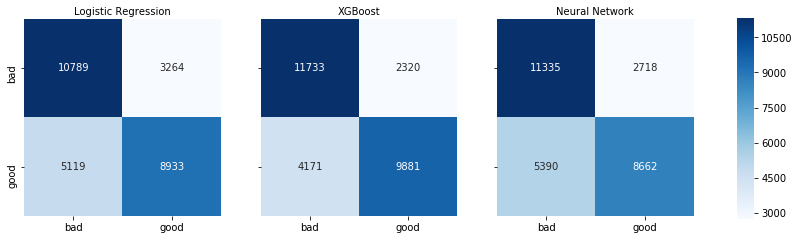

In [367]:
plot_heat_maps([conf_logistic, conf_xg, conf_nn], 
               titles = ["Logistic Regression", "XGBoost","Neural Network"])

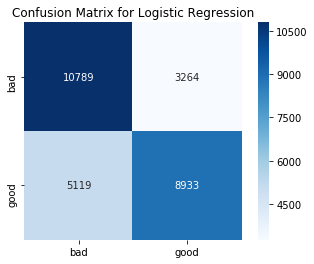

In [307]:
plt.title("Confusion Matrix for Logistic Regression")
sns.heatmap(conf_logistic, annot=True, fmt='g', square = True, cmap ="Blues",
            xticklabels = ["bad","good"], yticklabels = ["bad","good"])

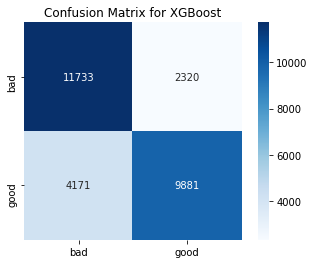

In [308]:
plt.title("Confusion Matrix for XGBoost")
sns.heatmap(conf_xg, annot=True, fmt='g', square = True, cmap ="Blues",
            xticklabels = ["bad","good"], yticklabels = ["bad","good"])

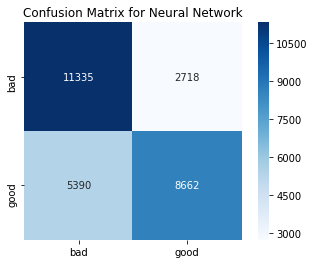

In [309]:
plt.title("Confusion Matrix for Neural Network")
sns.heatmap(conf_nn, annot=True, fmt='g', square = True, cmap ="Blues",
            xticklabels = ["bad","good"], yticklabels = ["bad","good"])